## Test Batch Normalization on tissues


**Question:** How does combat batch normalization algorithms perform on adjacent section tissues stained with the same panel, when training with unmatched cores?

**Samples:** 
- TMA: Purchased from biomax: https://www.biomax.us/tissue-arrays/Breast/BR1506
- Adjacent Sections: BM-Her2N75-15, BM-Her2N75-17, BM-Her2N75-18 (section 16 skipped.)
- Scenes: (i.e. TMA cores) 
  - 17: ER+/HER2+, immune rich. 
  - 49: ER+/HER2+
  - 59: HER2+ immune rich

**Method**: We performed combat normalization using unlike tissues as training set (different cores in training set and all cores in testing set). We visualized the resulting histograms.

In [54]:
#load libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import copy
import seaborn as sns
import importlib
import scanpy as sc
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale, minmax_scale, StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib as mpl
mpl.rc('figure', max_open_warning = 0)
os.chdir('//home/groups/graylab_share/OMERO.rdsStore/engje/Data/cmIF')
from mplex_image import visualize as viz, process, preprocess, normalize
np.random.seed(1202)

In [55]:
#change to correct directory
os.chdir('/home/groups/graylab_share/OMERO.rdsStore/engje/Data/cycIF_ValidationStudies/cycIF_Validation')
codedir=os.getcwd()
rootdir = f'{codedir}/Data/'
datadir = f'{codedir}/Data/filtered_data'
os.chdir(datadir)
%matplotlib inline

In [56]:
# load data
df=pd.read_csv(f'20201229_BM-Her2N75-15-17-18_MeanIntensity.csv',index_col=0)
df.rename({'slide':'batch'},axis=1,inplace=True)

In [57]:
#importlib.reload(normalize)

In [58]:
def plot_histograms(df_norm,df,s_train,s_tissue):
    df_norm['batch'] = [item.split('_')[0] for item in df_norm.index]
    bins=50
    for s_marker in df_norm.columns[df_norm.dtypes=='float64']:
        print(s_marker)
        fig,ax=plt.subplots(2,1,figsize = (5,5))
        for idxs, s_batch in enumerate(sorted(set(df_norm.batch))):
            df_batch = df_norm[(df_norm.batch==s_batch)].loc[:,s_marker] 
            if len(df_batch.dropna()) == 0:
                continue
            ax[0].hist(df.loc[df.index.str.contains(s_batch),s_marker],bins=bins,alpha=0.4, color=f'C{idxs}',label=s_batch)
            ax[1].hist(df_batch,bins=bins,alpha=0.4, color=f'C{idxs}',label=s_batch)
            ax[0].set_yscale('log')
            ax[1].set_yscale('log')
            ax[0].set_title(f'{s_marker.split("_")[0]}: Raw Data {s_train}')
            ax[1].set_title(f'{s_marker.split("_")[0]}: Combat')
            ax[0].legend()
        plt.tight_layout()
        fig.savefig(f'{rootdir}/20201228/Different_Scaling_combat_training_{s_train}_{s_marker}_{s_tissue}.png')


found 3 batches
found 0 numerical covariates...
found 0 categorical variables:	
Standardizing Data across genes.
Fitting L/S model and finding priors
Finding parametric adjustments
found 3 batches
found 0 numerical covariates...
found 0 categorical variables:	
Standardizing Data across genes.


Adjusting data
CD20_Ring
CD44_Ring
CD45_Ring
CD4_Ring
CD68_Ring
CD8_Ring
CK14_Ring
CK19_Ring
CK5_Ring
CK7_Ring
ER_Nuclei
Ecad_Ring
HER2_Ring
Ki67_Nuclei
LamAC_Nuclei
PCNA_Nuclei
PD1_Ring
Vim_Ring
aSMA_Ring
pHH3_Nuclei


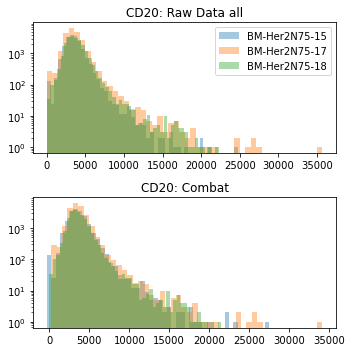

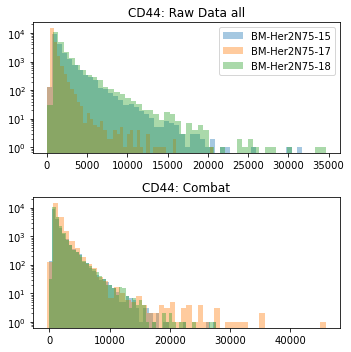

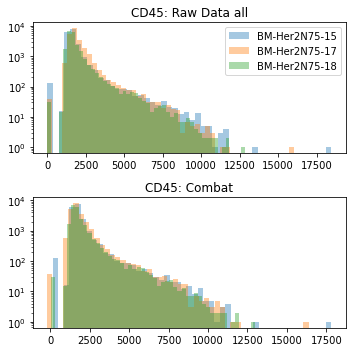

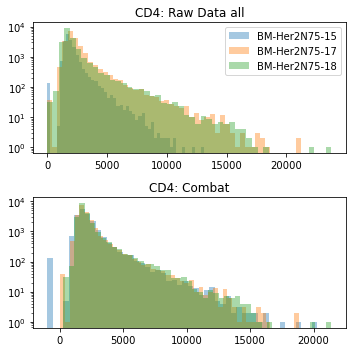

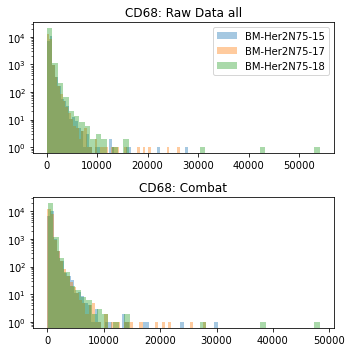

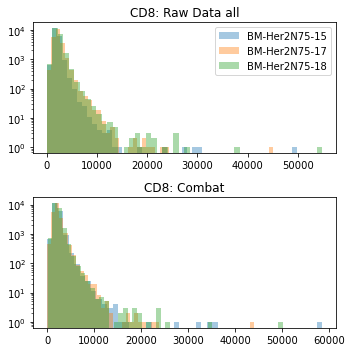

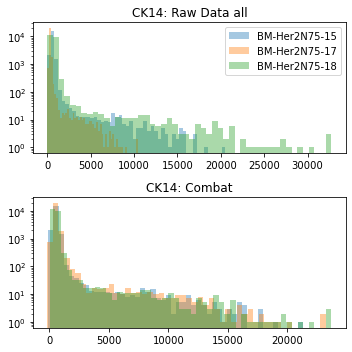

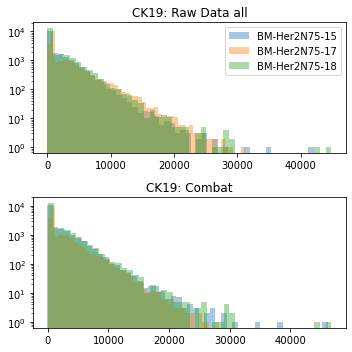

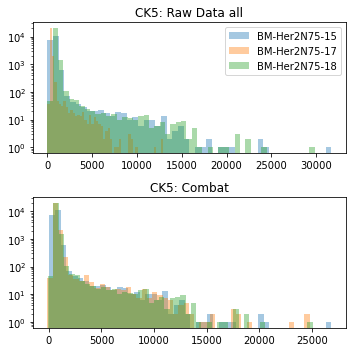

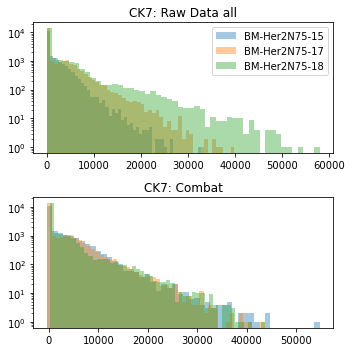

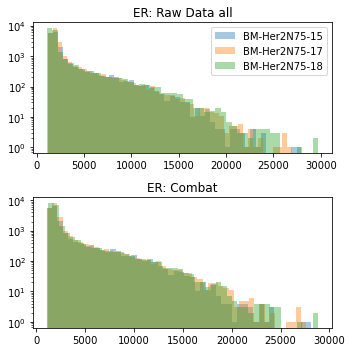

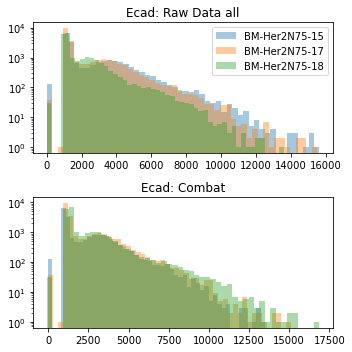

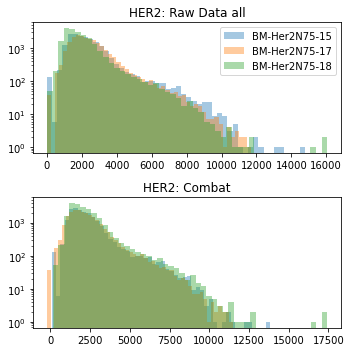

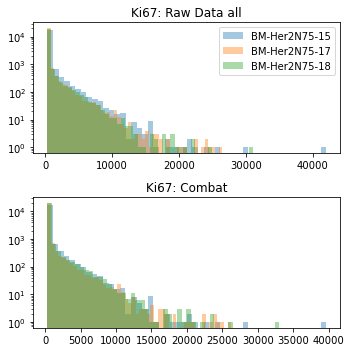

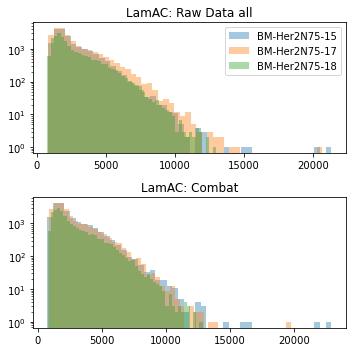

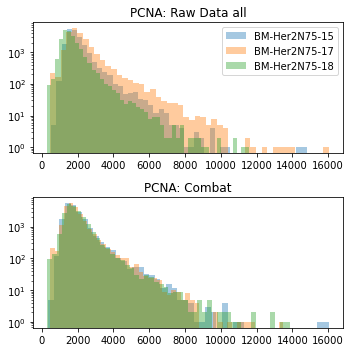

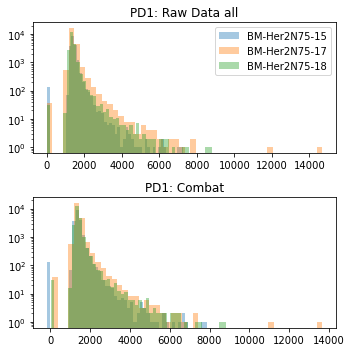

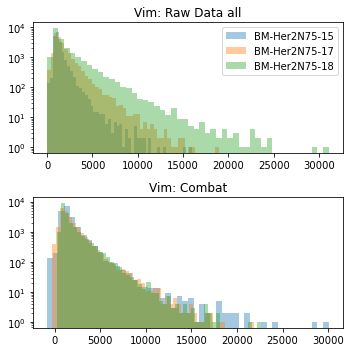

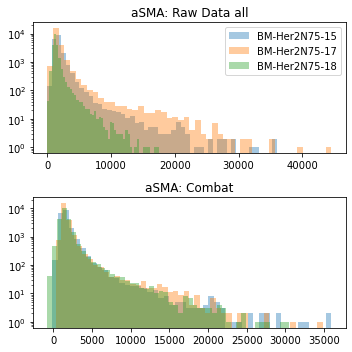

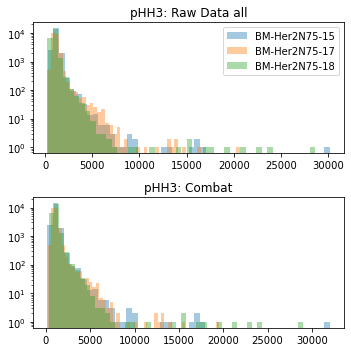

In [50]:
#all cores
data = df.loc[:,df.dtypes=='float64'].T
batch = df.batch
gamma_star, delta_star = normalize.combat_fit(data, batch)
#transform
bayesdata = normalize.combat_transform(data,batch,gamma_star, delta_star)
df_norm=bayesdata.T
s_train='all'
s_tissue = 'all'
plot_histograms(df_norm,df,s_train,s_tissue)

## Training combat with controls

How sensitive is the combat algorithm to the inputs that determine the parameters?

- Can different tissues in each batch be used to fit combat?
- Can a limited set of tissues be used to fit combat?
- Or, should the set of tissues used to fit combat be very similar to those it is applied to?

In [26]:
lls_batch = [['BM-Her2N75-15', 'BM-Her2N75-17', 'BM-Her2N75-18'],
            [ 'BM-Her2N75-17', 'BM-Her2N75-18','BM-Her2N75-15'],
            [ 'BM-Her2N75-18','BM-Her2N75-15', 'BM-Her2N75-17']]
ls_scene = sorted(set(df.scene))

found 3 batches
found 0 numerical covariates...
found 0 categorical variables:	
Standardizing Data across genes.
Fitting L/S model and finding priors
Finding parametric adjustments
found 3 batches
found 0 numerical covariates...
found 0 categorical variables:	
Standardizing Data across genes.


Adjusting data
CD20_Ring
CD44_Ring
CD45_Ring
CD4_Ring
CD68_Ring
CD8_Ring
CK14_Ring
CK19_Ring
CK5_Ring
CK7_Ring
ER_Nuclei
Ecad_Ring
HER2_Ring
Ki67_Nuclei
LamAC_Nuclei
PCNA_Nuclei
PD1_Ring
Vim_Ring
aSMA_Ring
pHH3_Nuclei


found 3 batches
found 0 numerical covariates...
found 0 categorical variables:	
Standardizing Data across genes.
Fitting L/S model and finding priors
Finding parametric adjustments
found 3 batches
found 0 numerical covariates...
found 0 categorical variables:	
Standardizing Data across genes.


Adjusting data
CD20_Ring
CD44_Ring
CD45_Ring
CD4_Ring
CD68_Ring
CD8_Ring
CK14_Ring
CK19_Ring
CK5_Ring
CK7_Ring
ER_Nuclei
Ecad_Ring
HER2_Ring
Ki67_Nuclei
LamAC_Nuclei
PCNA_Nuclei
PD1_Ring
Vim_Ring
aSMA_Ring
pHH3_Nuclei


found 3 batches
found 0 numerical covariates...
found 0 categorical variables:	
Standardizing Data across genes.
Fitting L/S model and finding priors
Finding parametric adjustments
found 3 batches
found 0 numerical covariates...
found 0 categorical variables:	
Standardizing Data across genes.


Adjusting data
CD20_Ring
CD44_Ring
CD45_Ring
CD4_Ring
CD68_Ring
CD8_Ring
CK14_Ring
CK19_Ring
CK5_Ring
CK7_Ring
ER_Nuclei
Ecad_Ring
HER2_Ring
Ki67_Nuclei
LamAC_Nuclei
PCNA_Nuclei
PD1_Ring
Vim_Ring
aSMA_Ring
pHH3_Nuclei


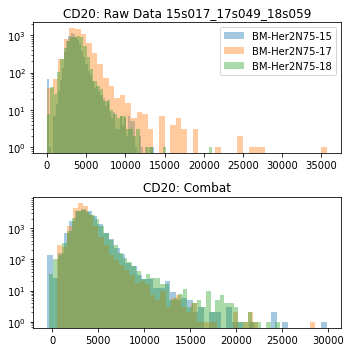

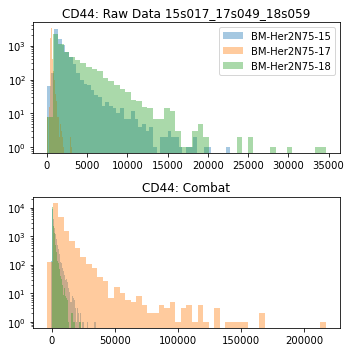

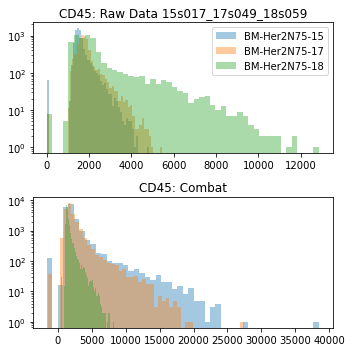

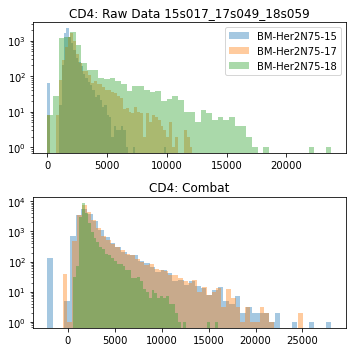

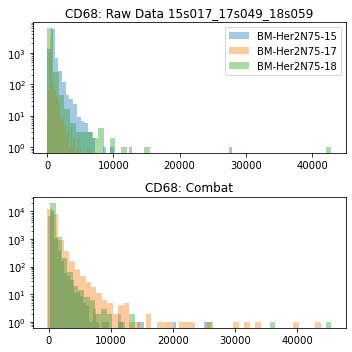

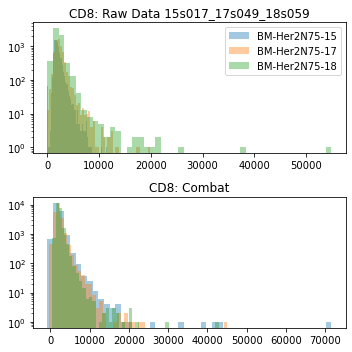

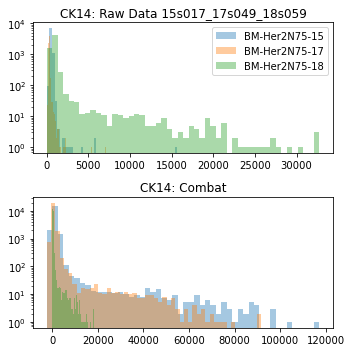

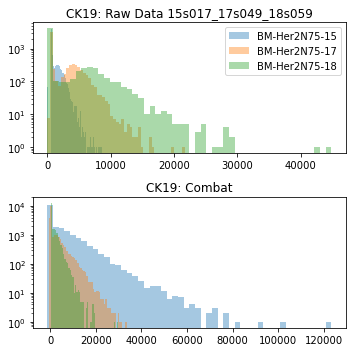

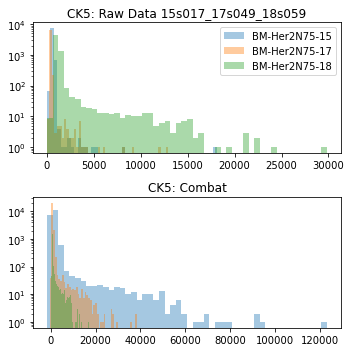

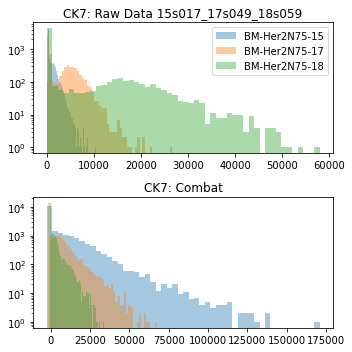

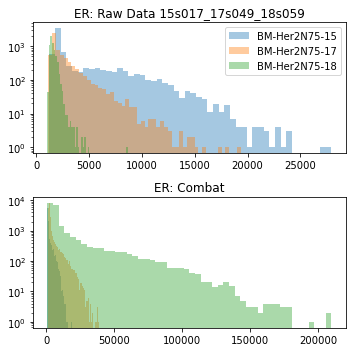

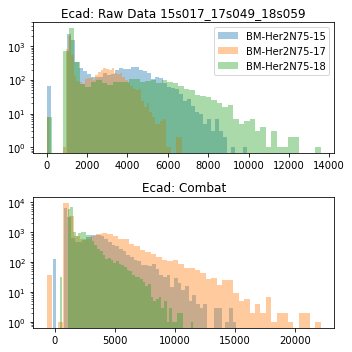

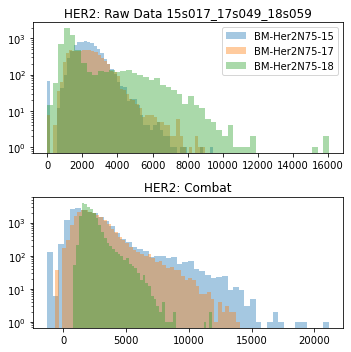

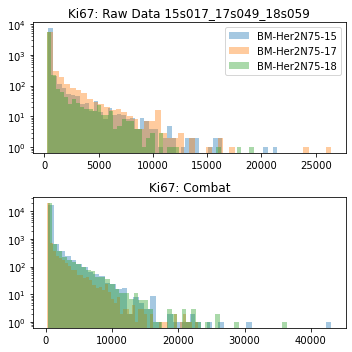

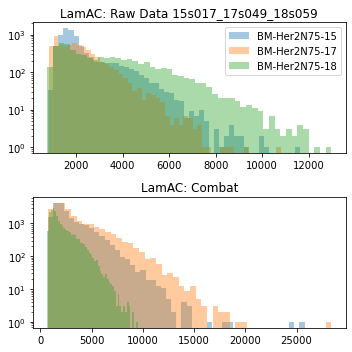

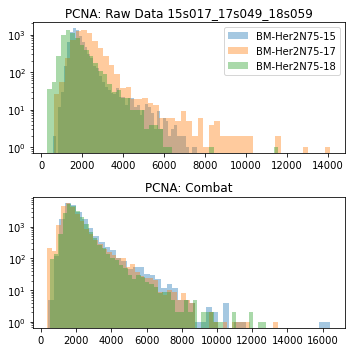

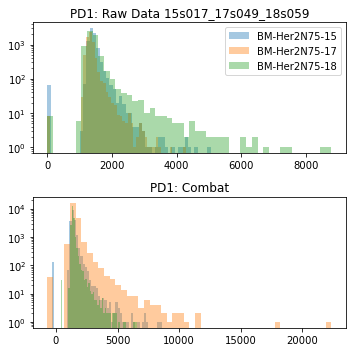

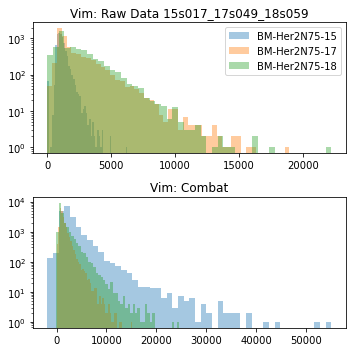

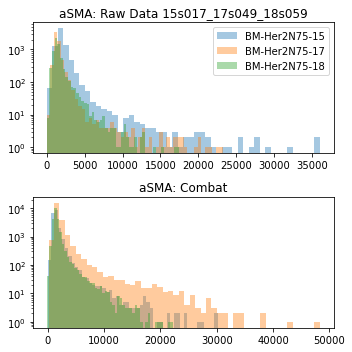

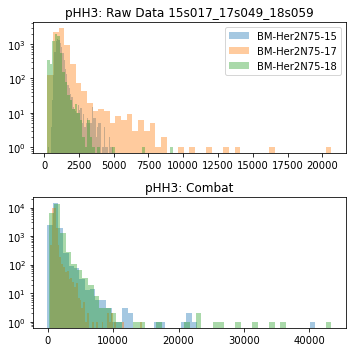

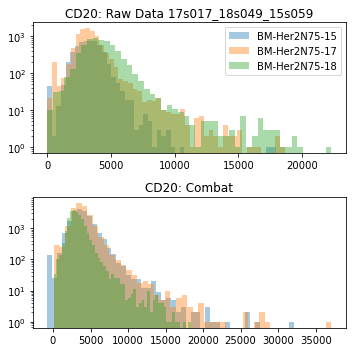

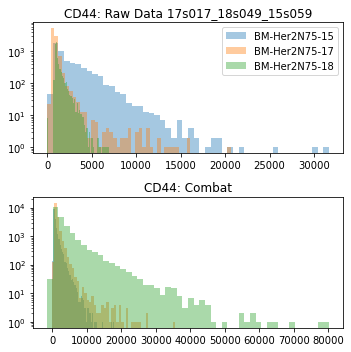

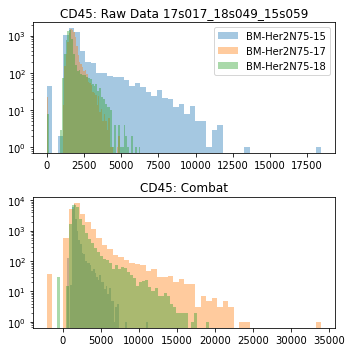

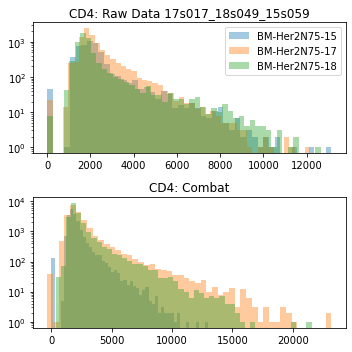

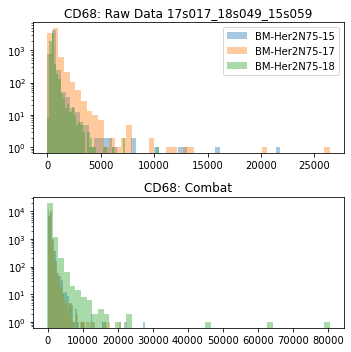

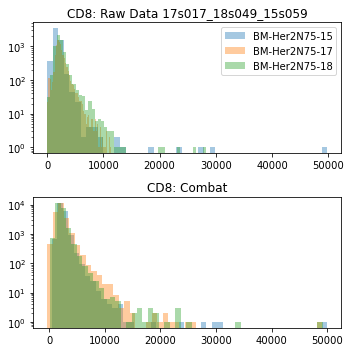

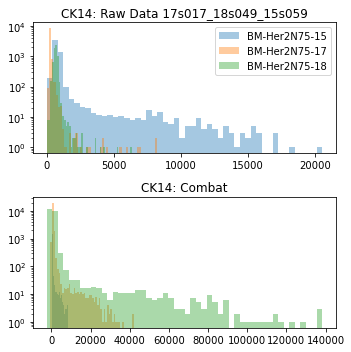

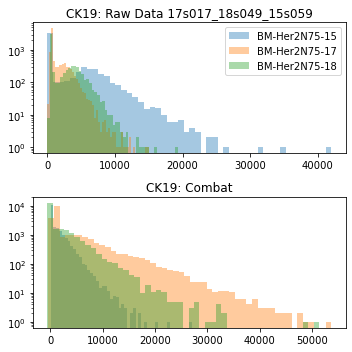

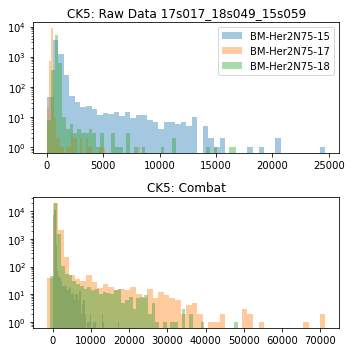

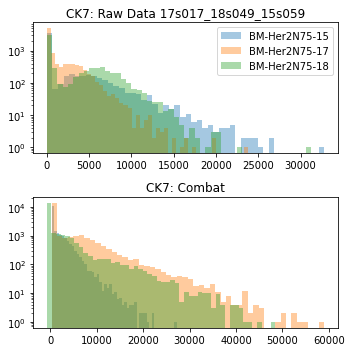

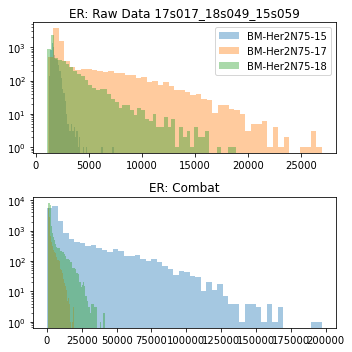

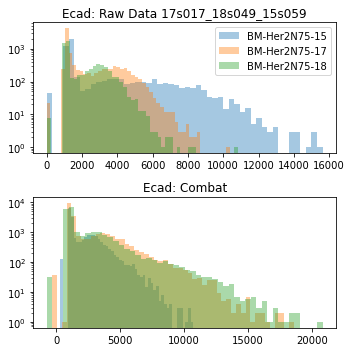

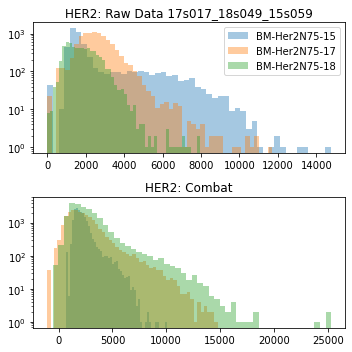

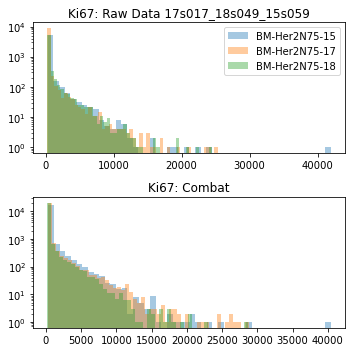

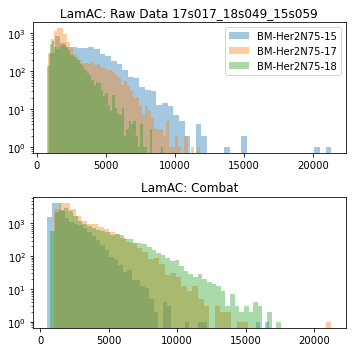

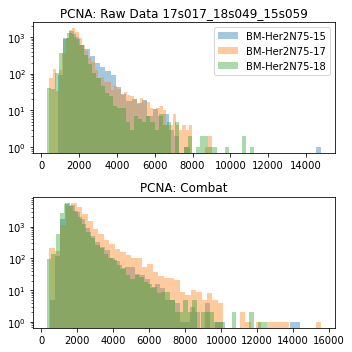

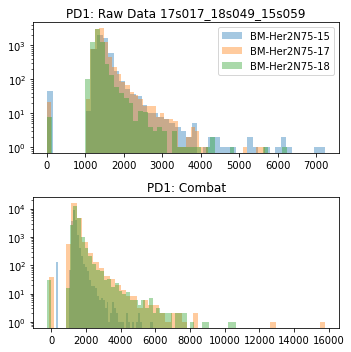

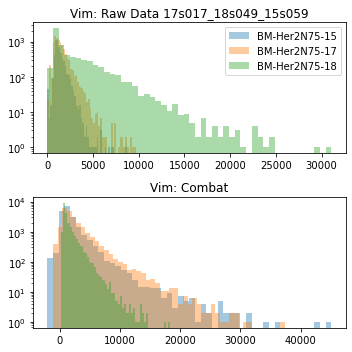

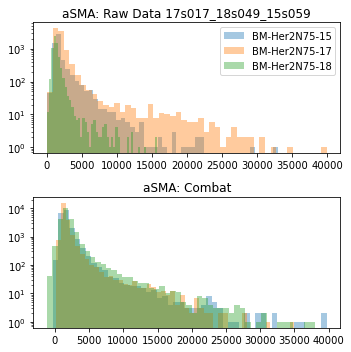

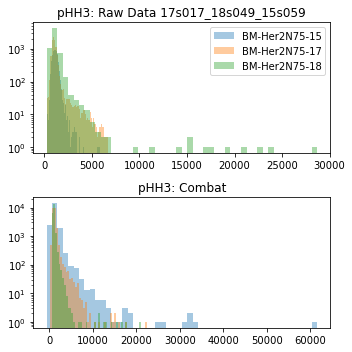

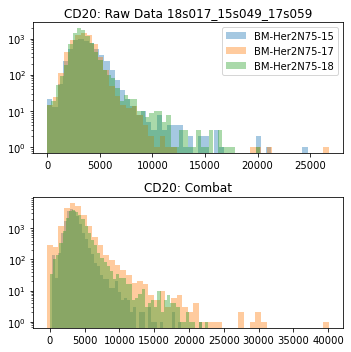

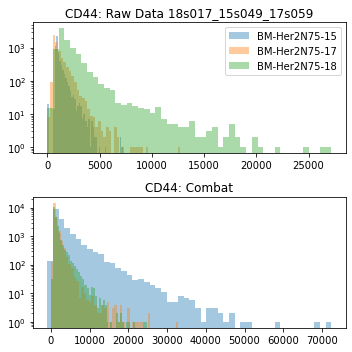

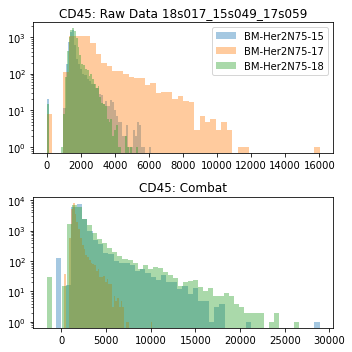

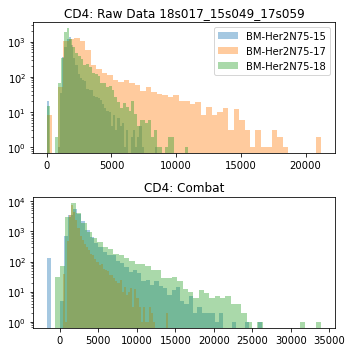

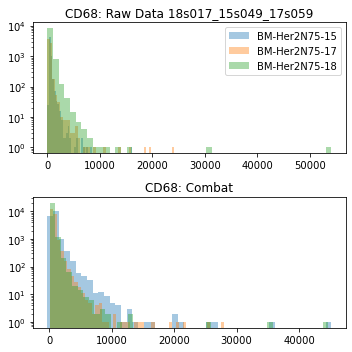

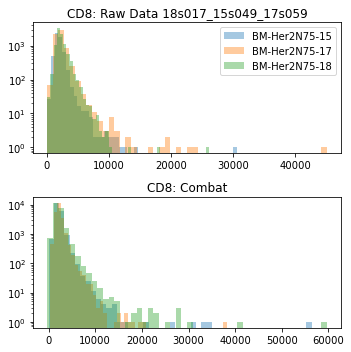

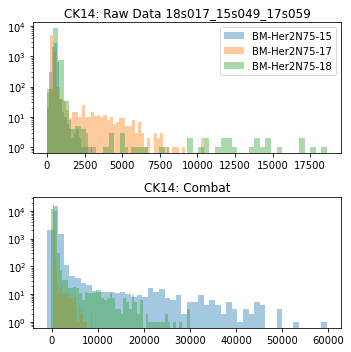

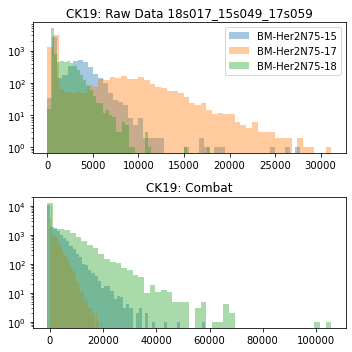

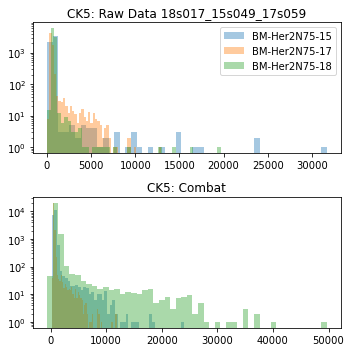

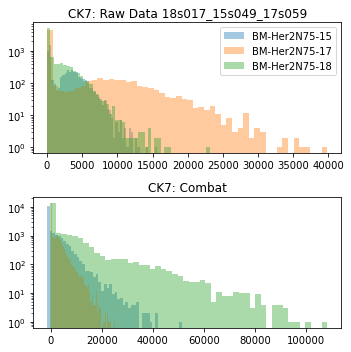

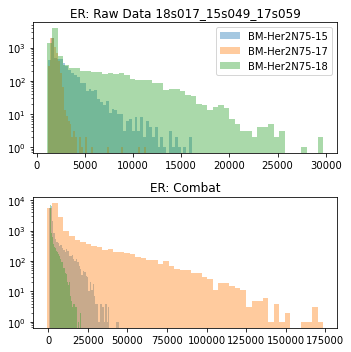

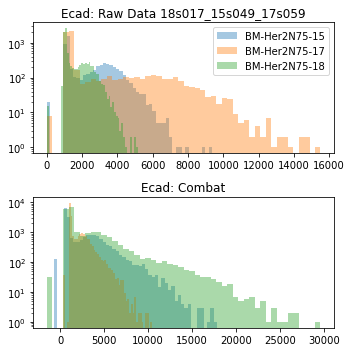

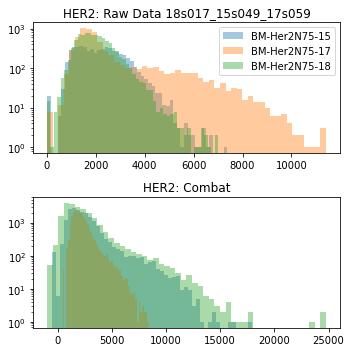

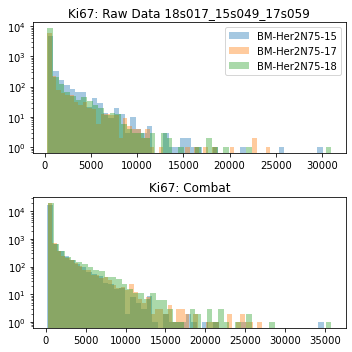

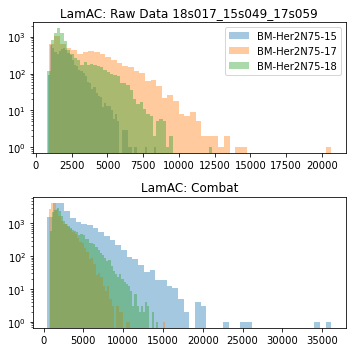

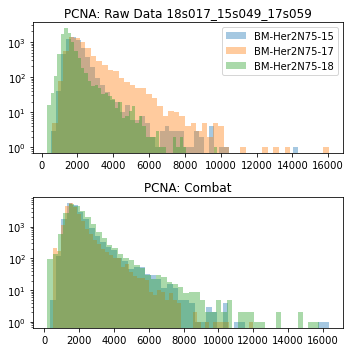

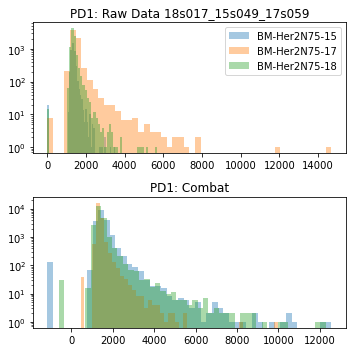

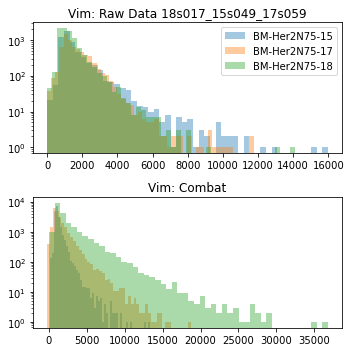

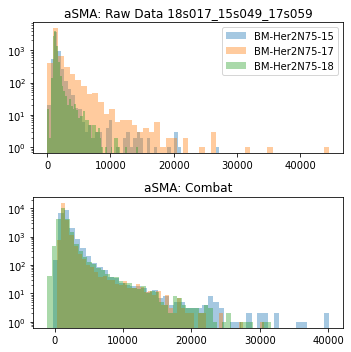

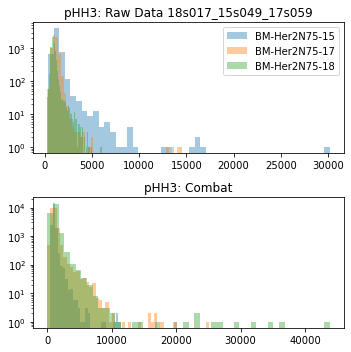

In [27]:
#normalize with different training sets
for idxx, ls_batch in enumerate(lls_batch):
    data = pd.DataFrame()
    for idx, s_batch in enumerate(ls_batch):
        s_scene = ['scene017', 'scene049', 'scene059'][idx]
        data = data.append(df.loc[((df.scene==s_scene)&(df.batch==s_batch)),:])   
    #fit training set
    gamma_star, delta_star = normalize.combat_fit(data.loc[:,data.dtypes=='float64'].T, data.batch)
    #transform full data set
    bayesdata = normalize.combat_transform(df.loc[:,df.dtypes=='float64'].T,df.batch,gamma_star, delta_star)
    df_norm=bayesdata.T
    s_train = "_".join([(item + ls_scene[idx]).split('-')[-1].replace('scene','s') for idx, item in enumerate(ls_batch)])
    s_tissue = 'all'
    plot_histograms(df_norm,data,s_train,s_tissue)
    df_norm.sample(5400,random_state=3).to_csv(f'20201229-{idxx}_BM-Her2N75_SampledMeanIntensity_diff_train.csv')

found 3 batches
found 0 numerical covariates...
found 0 categorical variables:	
Standardizing Data across genes.
Fitting L/S model and finding priors
Finding parametric adjustments
found 3 batches
found 0 numerical covariates...
found 0 categorical variables:	
Standardizing Data across genes.


Adjusting data
CD20_Ring
CD44_Ring
CD45_Ring
CD4_Ring
CD68_Ring
CD8_Ring
CK14_Ring
CK19_Ring
CK5_Ring
CK7_Ring
ER_Nuclei
Ecad_Ring
HER2_Ring
Ki67_Nuclei
LamAC_Nuclei
PCNA_Nuclei
PD1_Ring
Vim_Ring
aSMA_Ring
pHH3_Nuclei


found 3 batches
found 0 numerical covariates...
found 0 categorical variables:	
Standardizing Data across genes.
Fitting L/S model and finding priors
Finding parametric adjustments
found 3 batches
found 0 numerical covariates...
found 0 categorical variables:	
Standardizing Data across genes.


Adjusting data
CD20_Ring
CD44_Ring
CD45_Ring
CD4_Ring
CD68_Ring
CD8_Ring
CK14_Ring
CK19_Ring
CK5_Ring
CK7_Ring
ER_Nuclei
Ecad_Ring
HER2_Ring
Ki67_Nuclei
LamAC_Nuclei
PCNA_Nuclei
PD1_Ring
Vim_Ring
aSMA_Ring
pHH3_Nuclei


found 3 batches
found 0 numerical covariates...
found 0 categorical variables:	
Standardizing Data across genes.
Fitting L/S model and finding priors
Finding parametric adjustments
found 3 batches
found 0 numerical covariates...
found 0 categorical variables:	
Standardizing Data across genes.


Adjusting data
CD20_Ring
CD44_Ring
CD45_Ring
CD4_Ring
CD68_Ring
CD8_Ring
CK14_Ring
CK19_Ring
CK5_Ring
CK7_Ring
ER_Nuclei
Ecad_Ring
HER2_Ring
Ki67_Nuclei
LamAC_Nuclei
PCNA_Nuclei
PD1_Ring
Vim_Ring
aSMA_Ring
pHH3_Nuclei


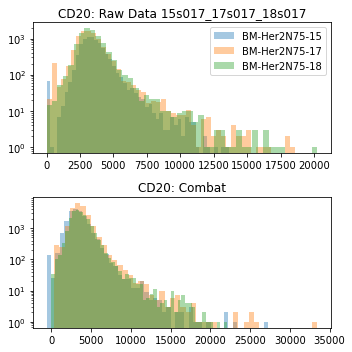

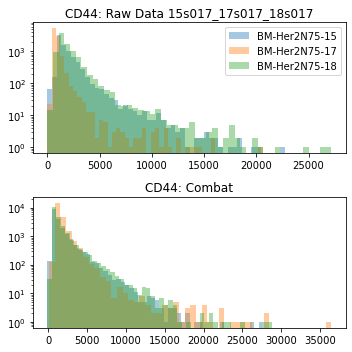

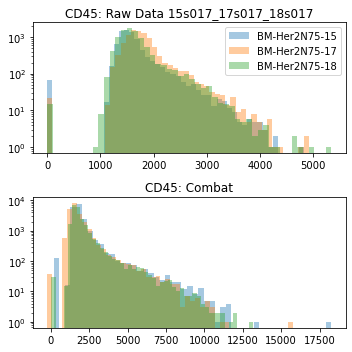

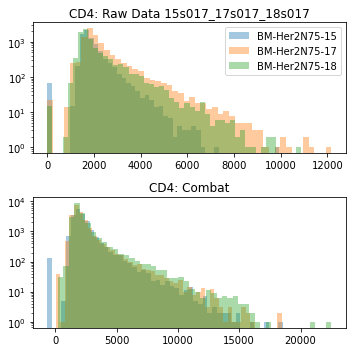

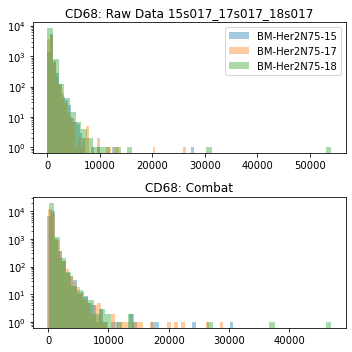

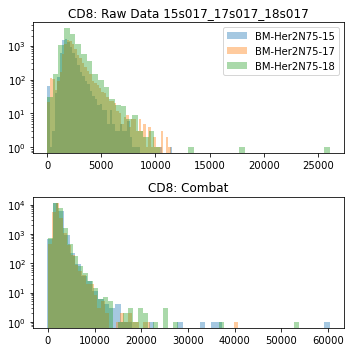

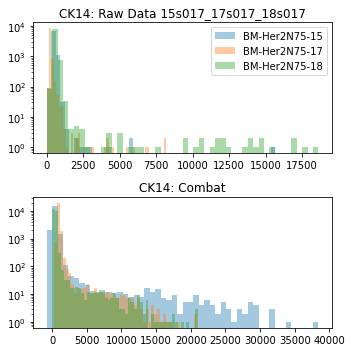

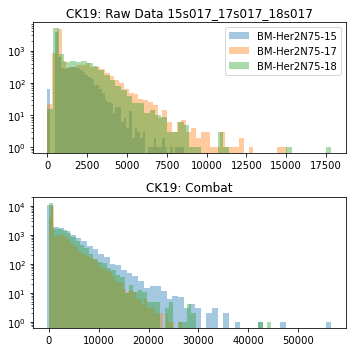

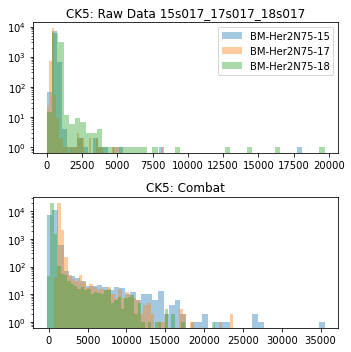

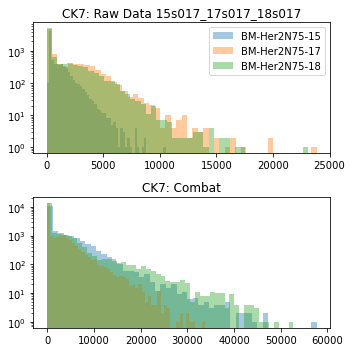

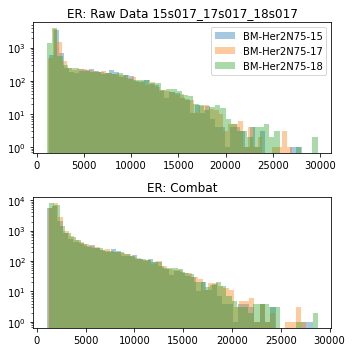

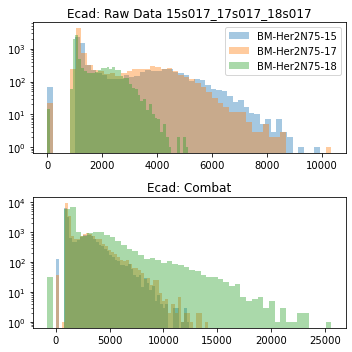

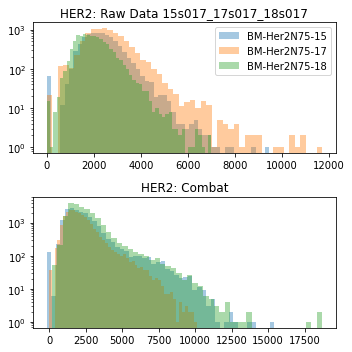

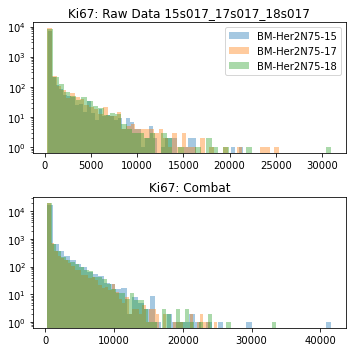

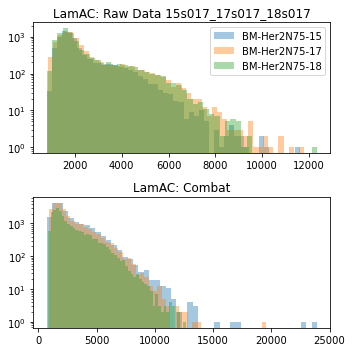

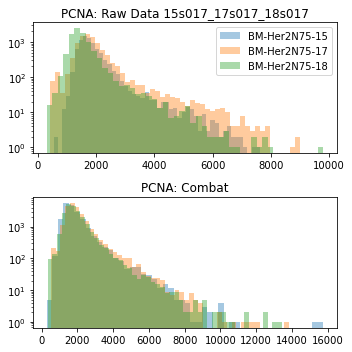

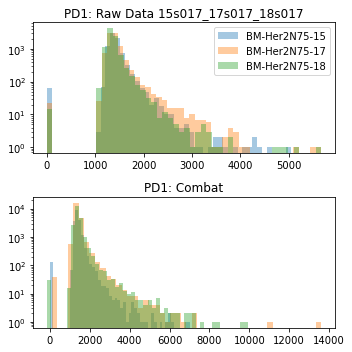

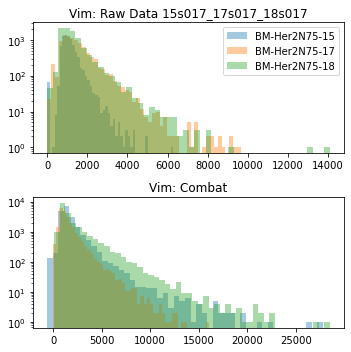

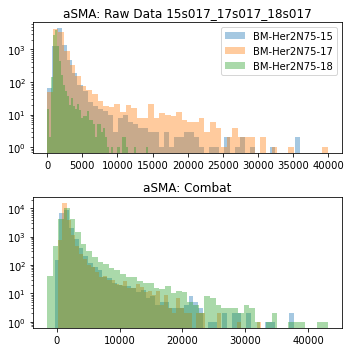

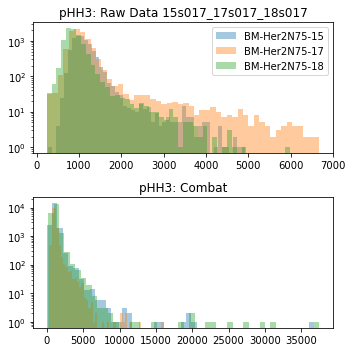

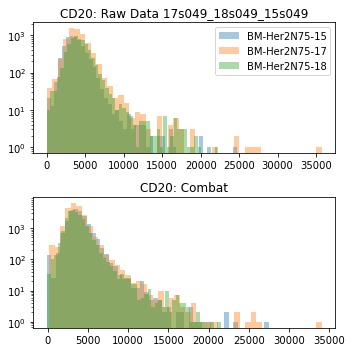

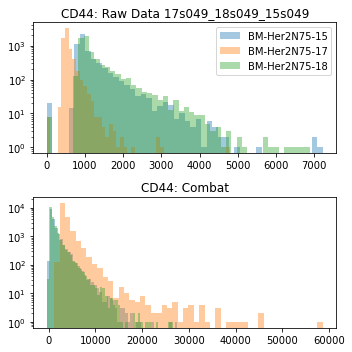

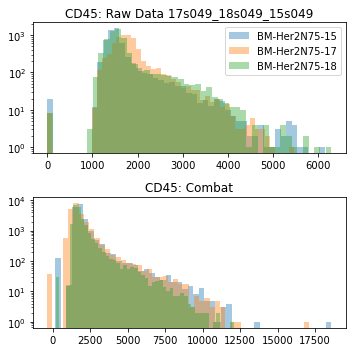

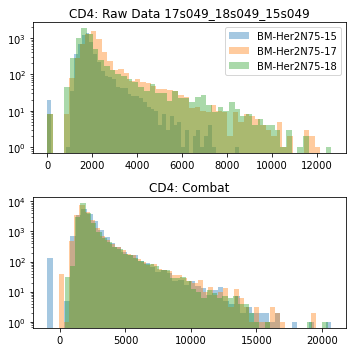

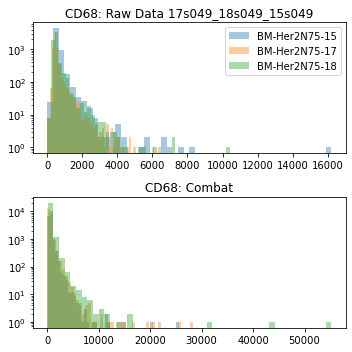

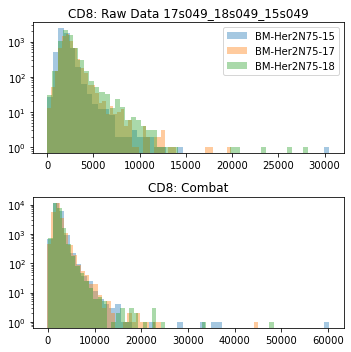

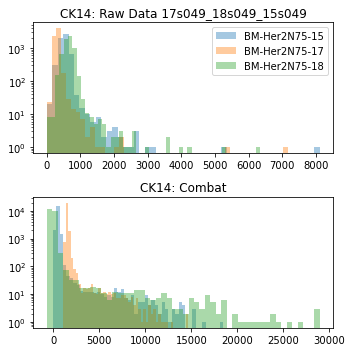

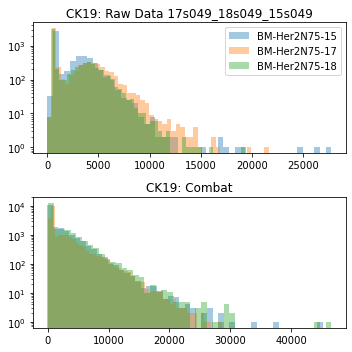

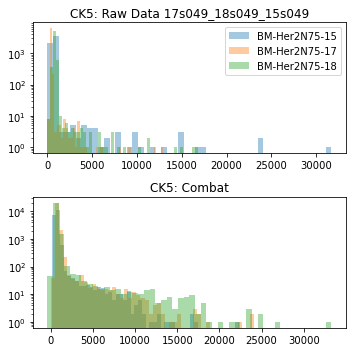

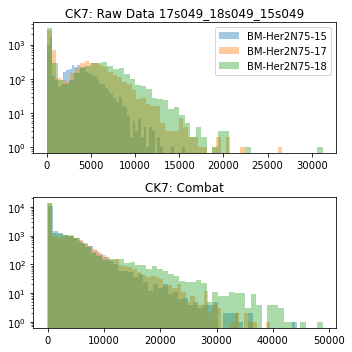

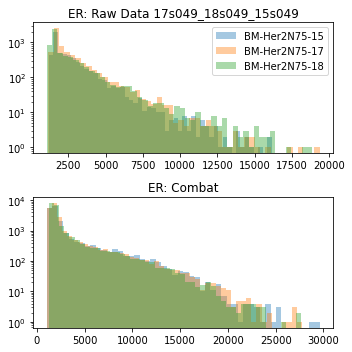

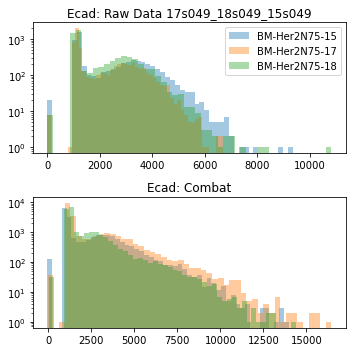

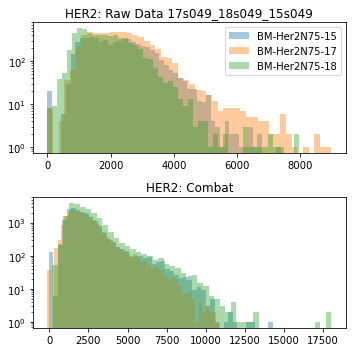

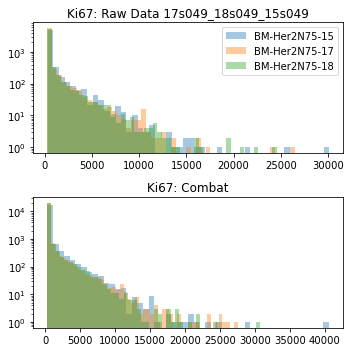

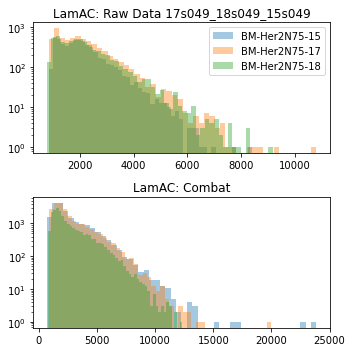

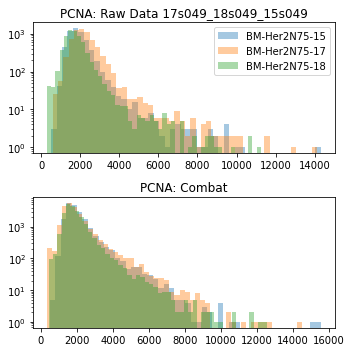

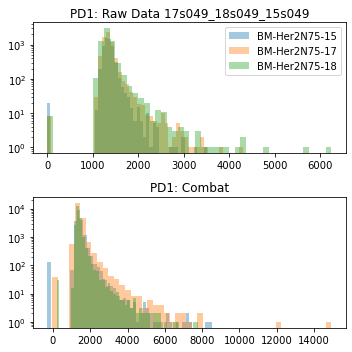

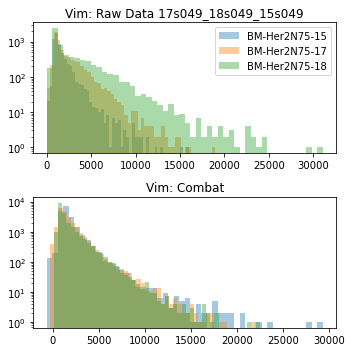

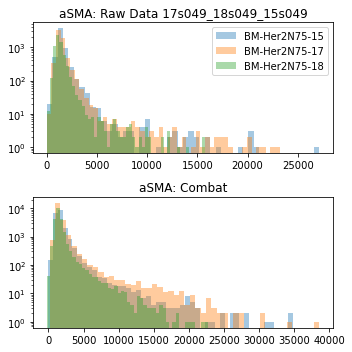

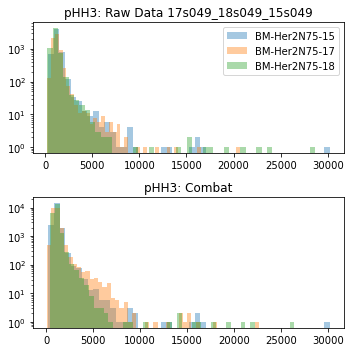

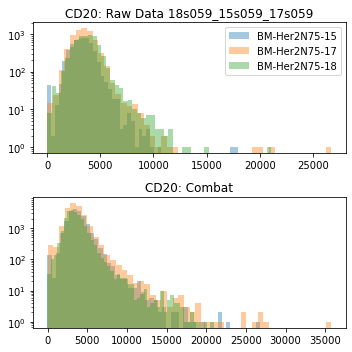

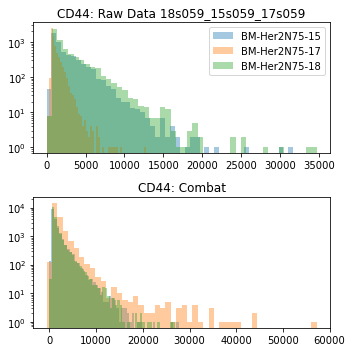

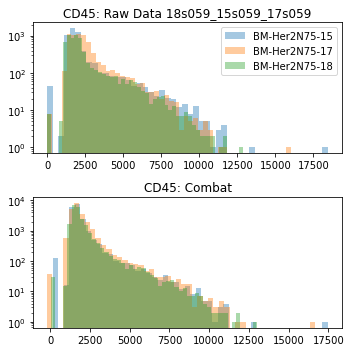

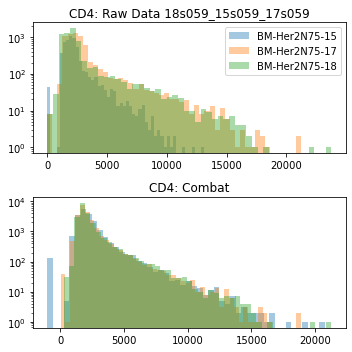

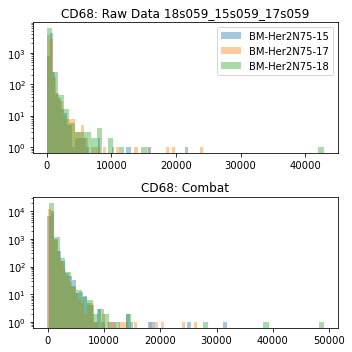

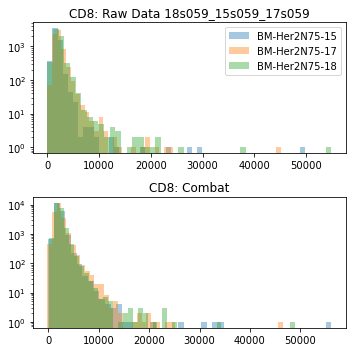

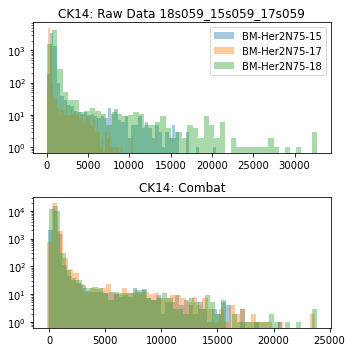

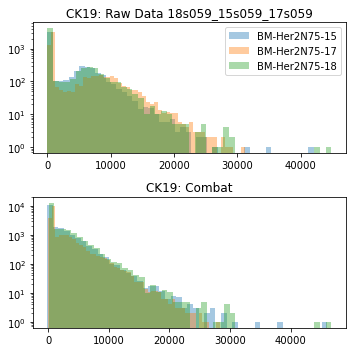

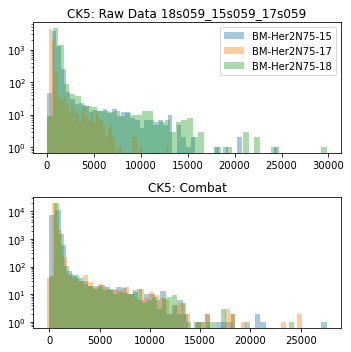

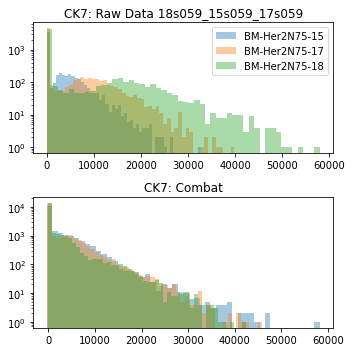

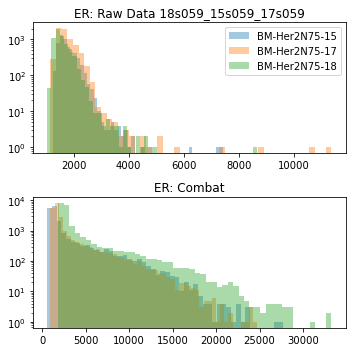

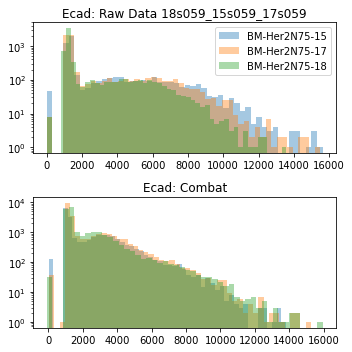

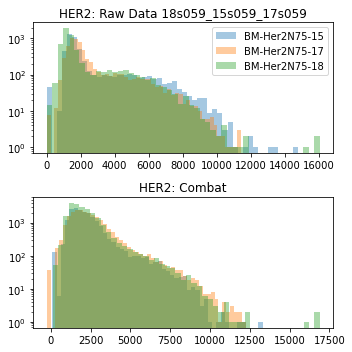

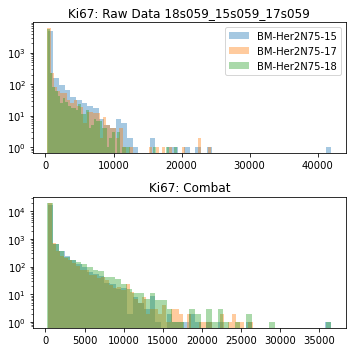

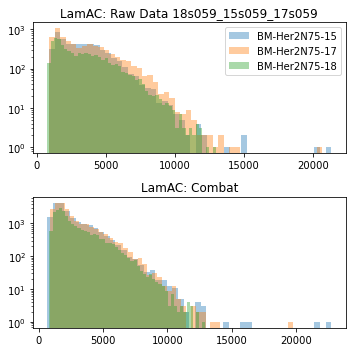

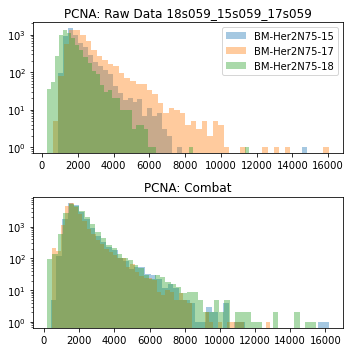

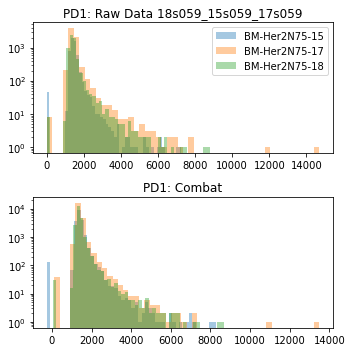

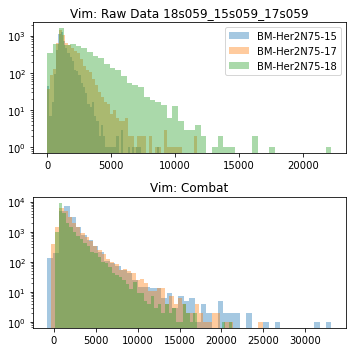

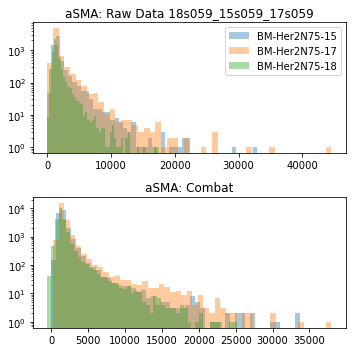

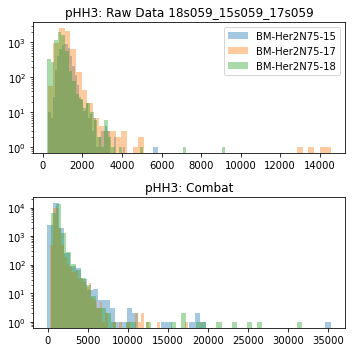

In [28]:
#normalize with same training sets
for idx, ls_batch in enumerate(lls_batch):
    s_scene = ['scene017', 'scene049', 'scene059'][idx]
    data = pd.DataFrame()
    for s_batch in ls_batch:   
        data = data.append(df.loc[((df.scene==s_scene)&(df.batch==s_batch)),:])   
    #fit training set
    gamma_star, delta_star = normalize.combat_fit(data.loc[:,data.dtypes=='float64'].T, data.batch)
    #transform full data set
    bayesdata = normalize.combat_transform(df.loc[:,df.dtypes=='float64'].T,df.batch,gamma_star, delta_star)
    df_norm=bayesdata.T
    s_train = "_".join([(item + s_scene).split('-')[-1].replace('scene','s') for idx, item in enumerate(ls_batch)])
    s_tissue = 'all'
    plot_histograms(df_norm,data,s_train,s_tissue)
    df_norm.sample(5400,random_state=3).to_csv(f'20201229-{idx}_BM-Her2N75_SampledMeanIntensity_same_train.csv')


found 3 batches
found 0 numerical covariates...
found 0 categorical variables:	
Standardizing Data across genes.
Fitting L/S model and finding priors
Finding parametric adjustments
found 3 batches
found 0 numerical covariates...
found 0 categorical variables:	
Standardizing Data across genes.


Adjusting data
CD20_Ring
CD44_Ring
CD45_Ring
CD4_Ring
CD68_Ring
CD8_Ring
CK14_Ring
CK19_Ring
CK5_Ring
CK7_Ring
ER_Nuclei
Ecad_Ring
HER2_Ring
Ki67_Nuclei
LamAC_Nuclei
PCNA_Nuclei
PD1_Ring
Vim_Ring
aSMA_Ring
pHH3_Nuclei


found 3 batches
found 0 numerical covariates...
found 0 categorical variables:	
Standardizing Data across genes.
Fitting L/S model and finding priors
Finding parametric adjustments
found 3 batches
found 0 numerical covariates...
found 0 categorical variables:	
Standardizing Data across genes.


Adjusting data
CD20_Ring
CD44_Ring
CD45_Ring
CD4_Ring
CD68_Ring
CD8_Ring
CK14_Ring
CK19_Ring
CK5_Ring
CK7_Ring
ER_Nuclei
Ecad_Ring
HER2_Ring
Ki67_Nuclei
LamAC_Nuclei
PCNA_Nuclei
PD1_Ring
Vim_Ring
aSMA_Ring
pHH3_Nuclei


found 3 batches
found 0 numerical covariates...
found 0 categorical variables:	
Standardizing Data across genes.
Fitting L/S model and finding priors
Finding parametric adjustments
found 3 batches
found 0 numerical covariates...
found 0 categorical variables:	
Standardizing Data across genes.


Adjusting data
CD20_Ring
CD44_Ring
CD45_Ring
CD4_Ring
CD68_Ring
CD8_Ring
CK14_Ring
CK19_Ring
CK5_Ring
CK7_Ring
ER_Nuclei
Ecad_Ring
HER2_Ring
Ki67_Nuclei
LamAC_Nuclei
PCNA_Nuclei
PD1_Ring
Vim_Ring
aSMA_Ring
pHH3_Nuclei


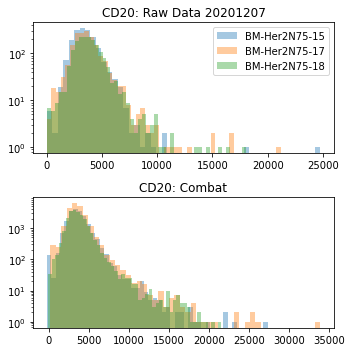

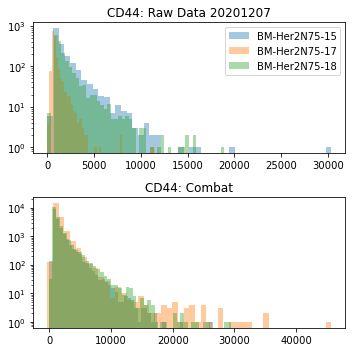

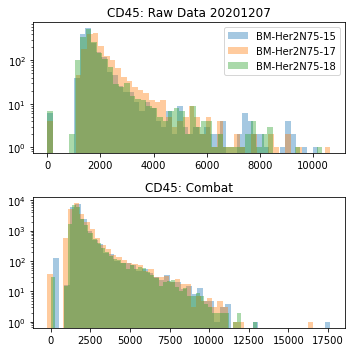

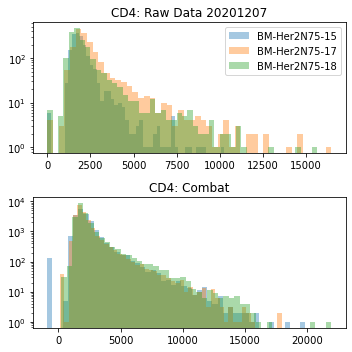

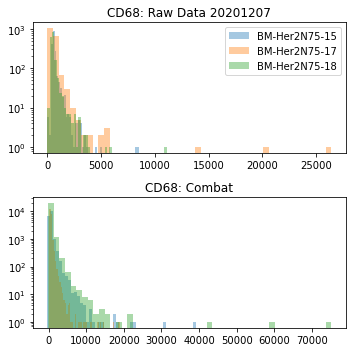

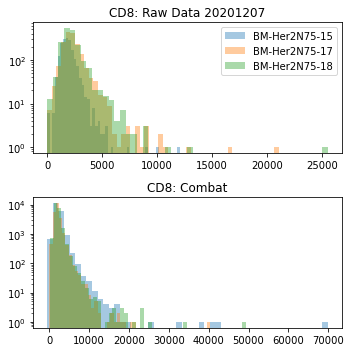

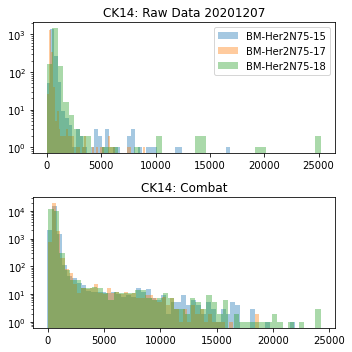

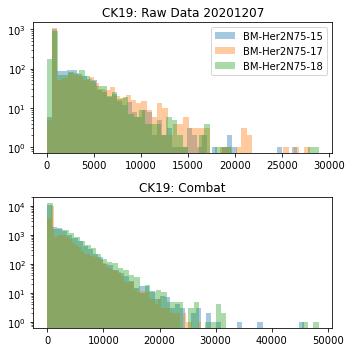

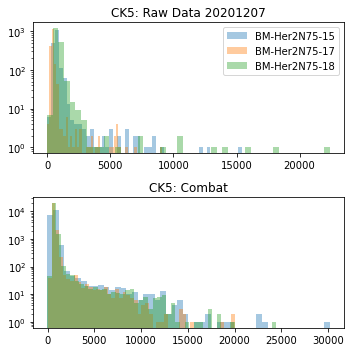

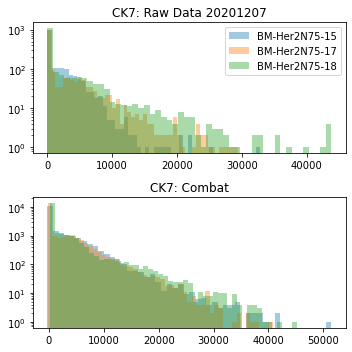

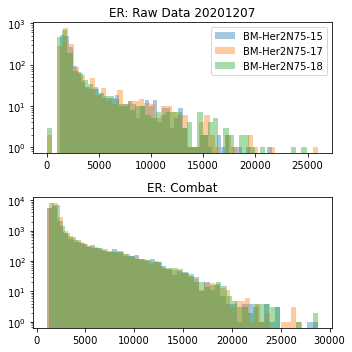

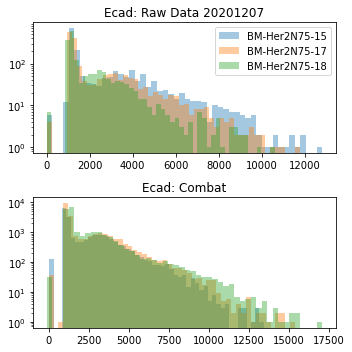

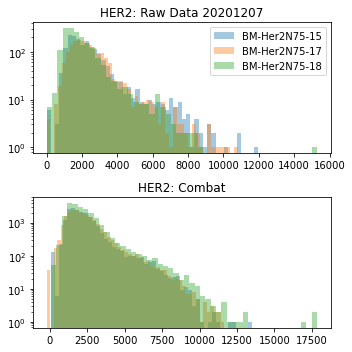

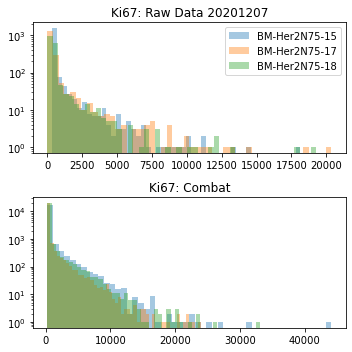

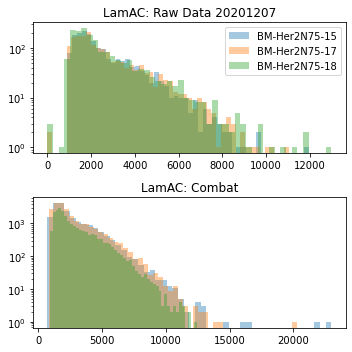

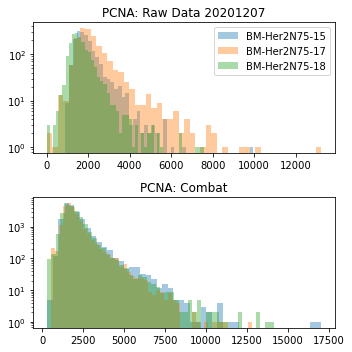

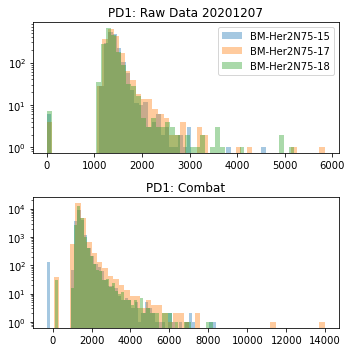

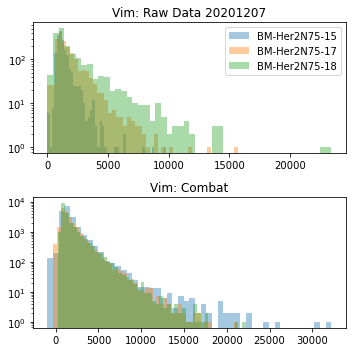

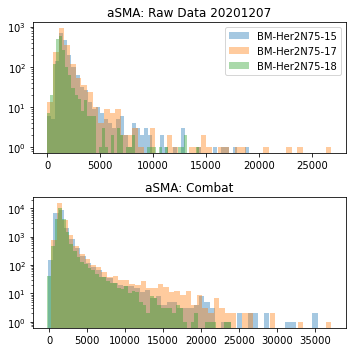

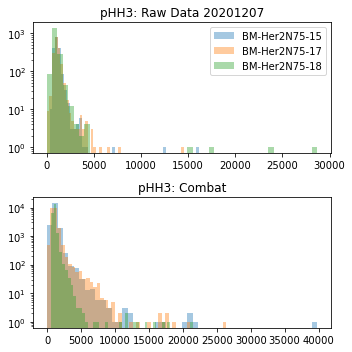

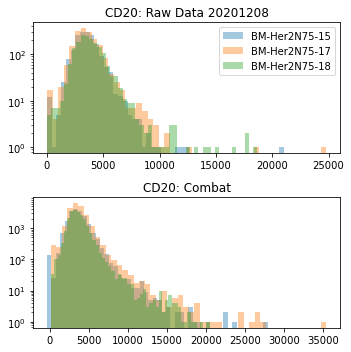

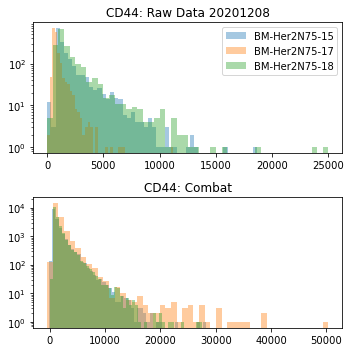

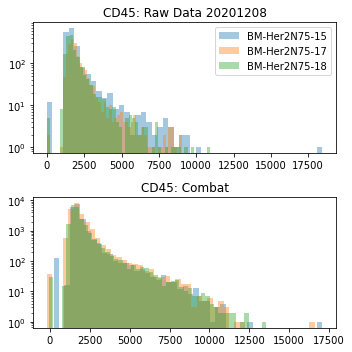

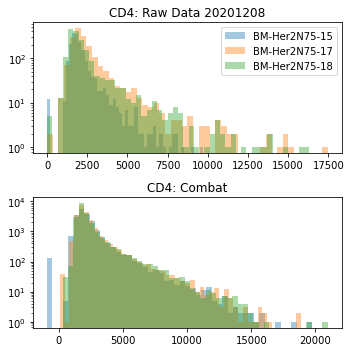

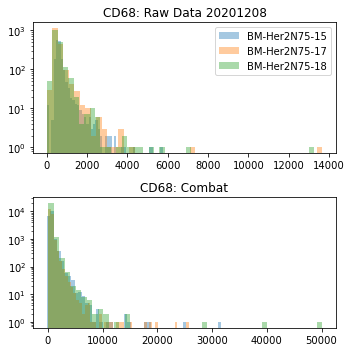

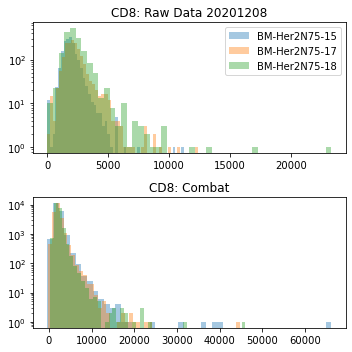

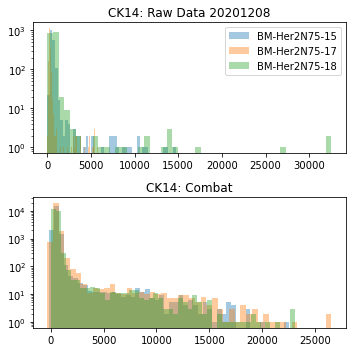

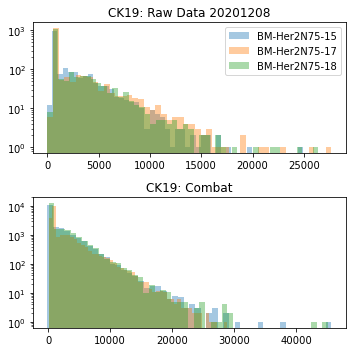

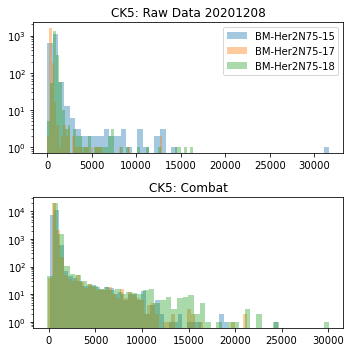

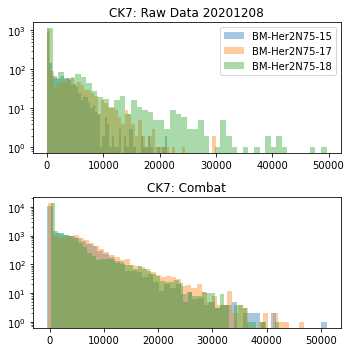

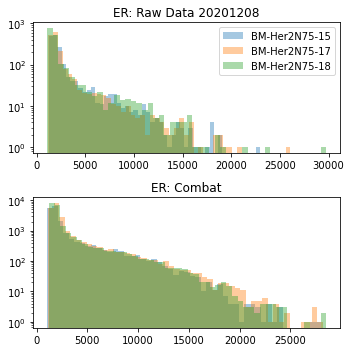

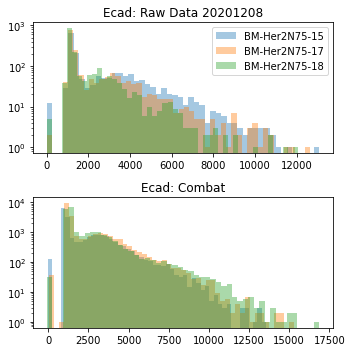

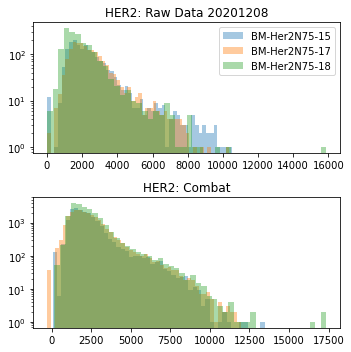

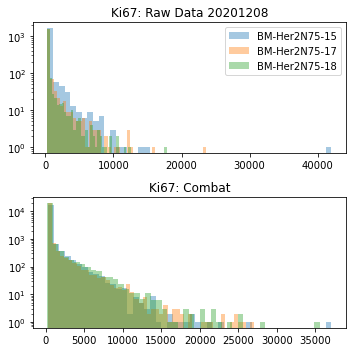

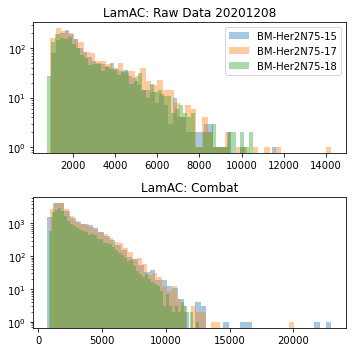

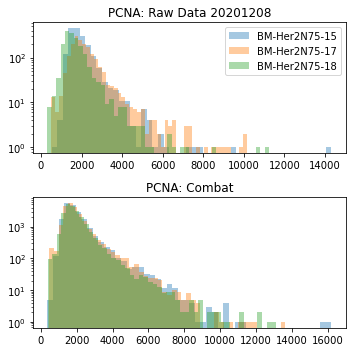

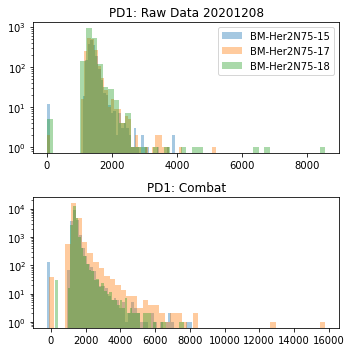

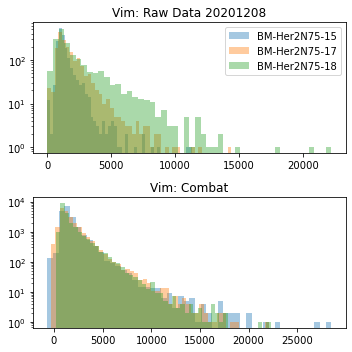

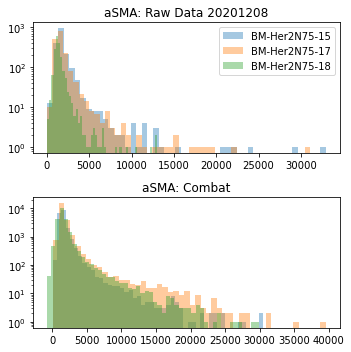

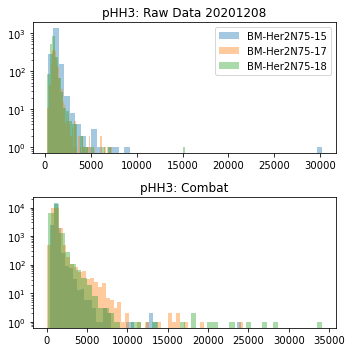

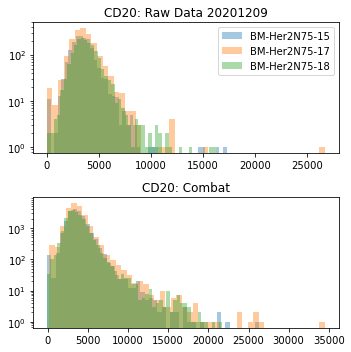

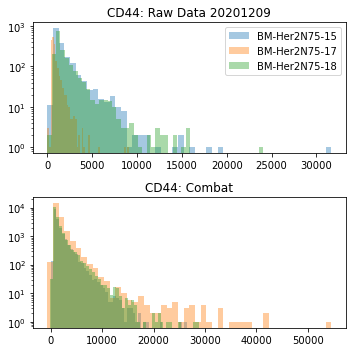

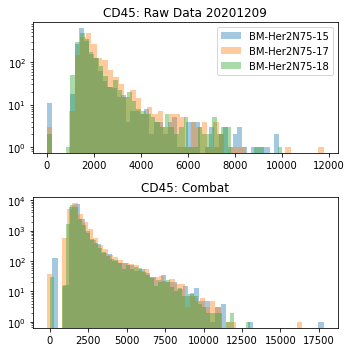

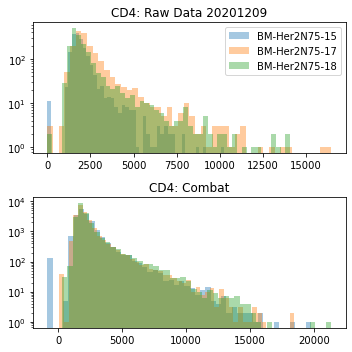

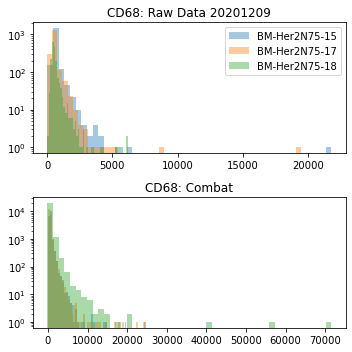

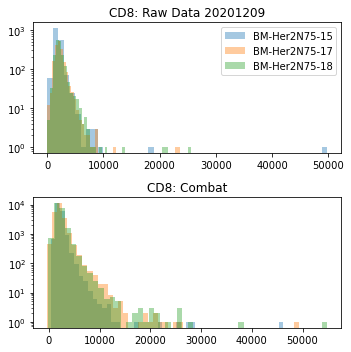

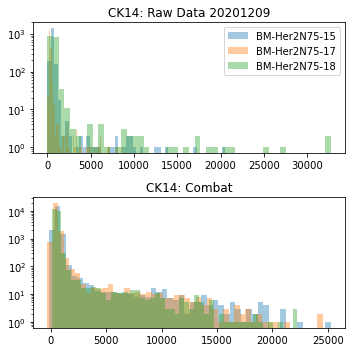

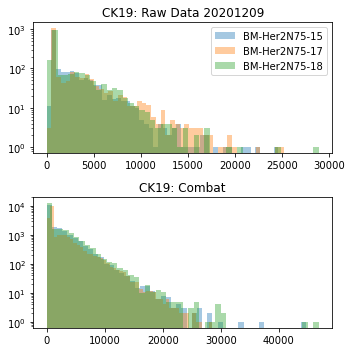

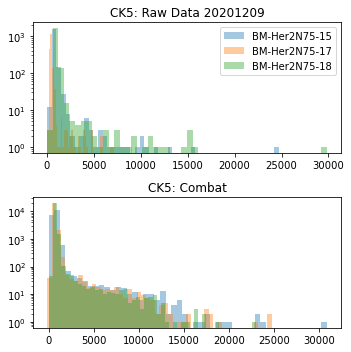

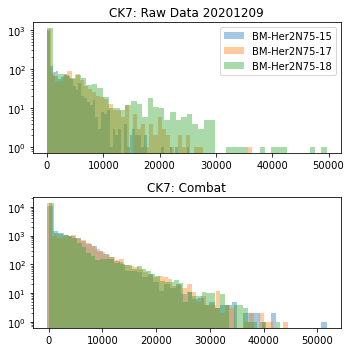

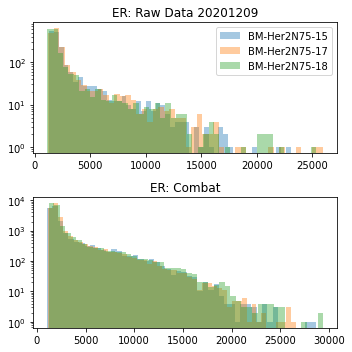

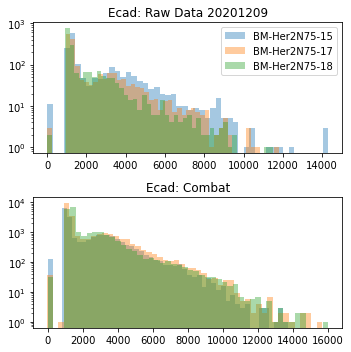

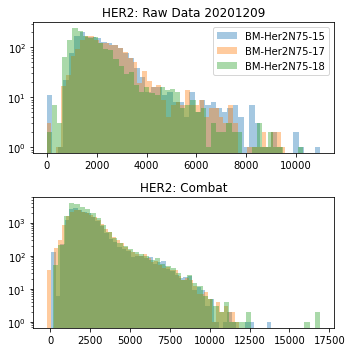

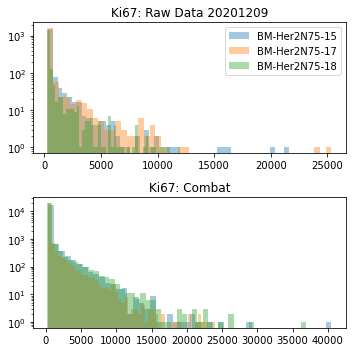

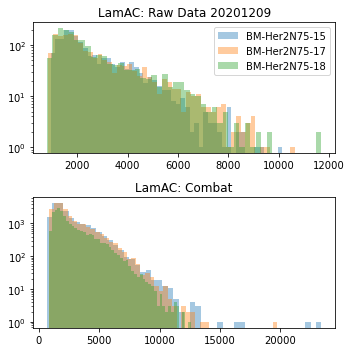

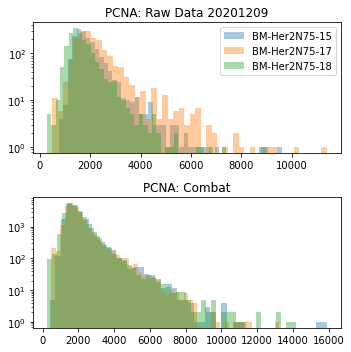

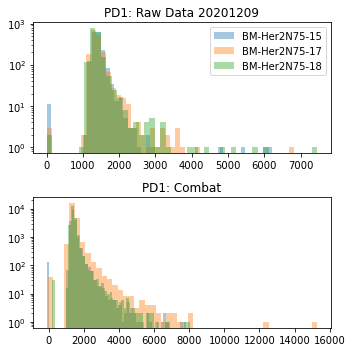

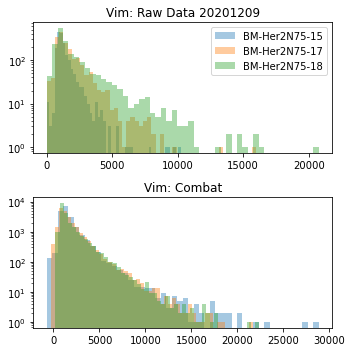

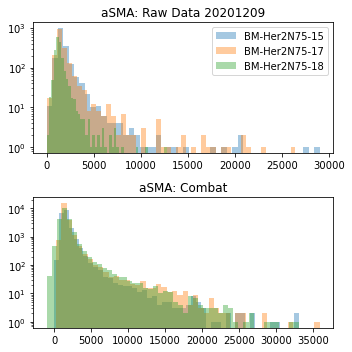

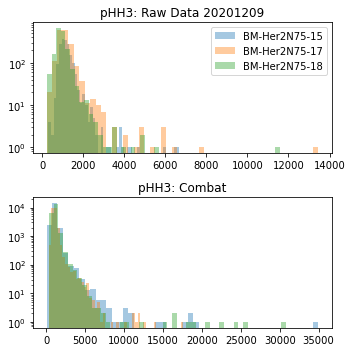

In [25]:
#normalize with sampled training sets
ls_date = ['20201207','20201208','20201209']
for idx, s_date in enumerate(ls_date):
    data = pd.read_csv(f'{s_date}_BM-Her2N75-15-17-18_SampledMeanIntensity_raw.csv',index_col=0)
    data['batch'] = [item.split('_')[0] for item in data.index]
    #fit training set
    gamma_star, delta_star = normalize.combat_fit(data.loc[:,data.dtypes=='float64'].T, data.batch)
    #transform full data set
    bayesdata = normalize.combat_transform(df.loc[:,df.dtypes=='float64'].T,df.batch,gamma_star, delta_star)
    df_norm=bayesdata.T
    s_train = s_date
    s_tissue = 'all'
    plot_histograms(df_norm,data,s_train,s_tissue)
    df_norm.sample(5400,random_state=3).to_csv(f'20201229-{idx}_BM-Her2N75_SampledMeanIntensity_sampled_train.csv')


## Training combat with controls: Results

How sensitive is the combat algorithm to the inputs that determine the parameters?

- Can different tissues in each batch be used to fit combat? - **No, kbet rejection rate is near 1**
- Can a limited set of tissues be used to fit combat? - **Varies, kbet rejection from 0.85 to 1, depending on training tissue**
- Or, should the set of tissues used to fit combat be very similar to those it is applied to? - **Yes, lowest kbet rejection rate**

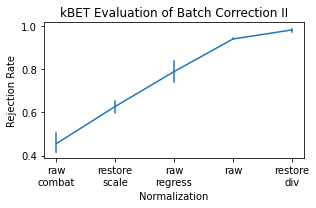

In [52]:
#os.chdir(filterdir)
df_file = pd.DataFrame(index=os.listdir())
df_file = df_file[df_file.index.str.contains('BM-Her2N75-15-17-18_kbet_')]
#ls_train = ['diff_train','raw', 'same_train', 'sampled_train','raw_combat']
ls_method = ['raw', 'raw_combat', 'raw_regress_out',  'restore_div', 'restore_scale']#,'raw_restore_combat' 'raw_restore','raw_restore_regress_out',

#add mean kbet
for s_file in df_file.index:
    df = pd.read_csv(s_file,index_col=0)
    df_file.loc[s_file,'mean_kbet'] = df.loc['mean','kBET.observed']
df_file['norm'] = [item.split('kbet_')[1].split('.csv')[0] for item in df_file.index]
df_file = df_file[df_file.norm.isin(ls_method)]
ls_index= df_file.groupby('norm').mean_kbet.mean().sort_values().index
df_file.groupby('norm').mean_kbet.mean().sort_values()
df_file['Norm'] = pd.Categorical(
    df_file['norm'], 
    categories=ls_index.tolist(), 
    ordered=True
)
%matplotlib inline
fig, ax = plt.subplots(figsize=(4.5,3))
df_plot = df_file.sort_values('Norm')
sns.lineplot(data=df_plot,x='norm',y='mean_kbet',ax=ax,err_style='bars')
labels = [item.replace('_out','').replace('_','\n') for item in ls_index.tolist()]
ax.set_xticks(range(len(df_file.groupby('norm').mean_kbet)))
ax.set_xticklabels(labels,rotation=0)
ax.set_ylabel('Rejection Rate')
ax.set_xlabel('Normalization')
ax.set_title('kBET Evaluation of Batch Correction II')
fig.set_tight_layout(True)
plt.tight_layout
fig.savefig(f'{rootdir}/20201228/BatchEffectII.png',dpi=200)

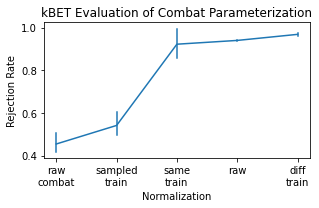

In [53]:
#add mean kbet
df_file = pd.DataFrame(index=os.listdir())
df_file = df_file[df_file.index.str.contains('BM-Her2N75-15-17-18_kbet_')]
ls_train = ['diff_train','raw', 'same_train', 'sampled_train','raw_combat']
for s_file in df_file.index:
    df = pd.read_csv(s_file,index_col=0)
    df_file.loc[s_file,'mean_kbet'] = df.loc['mean','kBET.observed']
df_file['norm'] = [item.split('kbet_')[1].split('.csv')[0] for item in df_file.index]
df_file = df_file[df_file.norm.isin(ls_train)]
ls_index= df_file.groupby('norm').mean_kbet.mean().sort_values().index
df_file.groupby('norm').mean_kbet.mean().sort_values()
df_file['Norm'] = pd.Categorical(
    df_file['norm'], 
    categories=ls_index.tolist(), 
    ordered=True
)
%matplotlib inline
fig, ax = plt.subplots(figsize=(4.5,3))
df_plot = df_file.sort_values('Norm')
sns.lineplot(data=df_plot,x='norm',y='mean_kbet',ax=ax,err_style='bars')
labels = [item.replace('_out','').replace('_','\n') for item in ls_index.tolist()]
ax.set_xticks(range(len(df_file.groupby('norm').mean_kbet)))
ax.set_xticklabels(labels,rotation=0)
ax.set_ylabel('Rejection Rate')
ax.set_xlabel('Normalization')
ax.set_title('kBET Evaluation of Combat Parameterization')
fig.set_tight_layout(True)
plt.tight_layout
fig.savefig(f'{rootdir}/20201228/BatchEffect_CombatParam.png',dpi=200)

In [43]:
df_plot

,mean_kbet,norm,Norm
20201207_BM-Her2N75-15-17-18_kbet_raw_combat.csv,0.416722,raw_combat,raw_combat
20201209_BM-Her2N75-15-17-18_kbet_raw_combat.csv,0.441778,raw_combat,raw_combat
20201208_BM-Her2N75-15-17-18_kbet_raw_combat.csv,0.504593,raw_combat,raw_combat
20201229-0_BM-Her2N75-15-17-18_kbet_sampled_train.csv,0.477352,sampled_train,sampled_train
20201229-1_BM-Her2N75-15-17-18_kbet_sampled_train.csv,0.604778,sampled_train,sampled_train
20201229-2_BM-Her2N75-15-17-18_kbet_sampled_train.csv,0.541741,sampled_train,sampled_train
20201229-0_BM-Her2N75-15-17-18_kbet_same_train.csv,0.911204,same_train,same_train
20201229-2_BM-Her2N75-15-17-18_kbet_same_train.csv,0.859407,same_train,same_train
20201229-1_BM-Her2N75-15-17-18_kbet_same_train.csv,0.995130,same_train,same_train
20201207_BM-Her2N75-15-17-18_kbet_raw.csv,0.938593,raw,raw
